In [ ]:
%config Completer.use_jedi = False

Run before benchmark if there is a GPU memory error, to run experiments using CPU device

In [1]:
import tensorflow as tf
tf.config.experimental.set_visible_devices([], 'GPU')

# LIPS : Learning Industrial physical simulationbenchmark suite: the power grid case

The benchmarking platform (as it can be observed in Figure below) is composed of three main modules which are Data, Benchmarking and Evaluation. As the names suggest, each module is specialized with its own set of functions for a specific task. The Data module is the one that helps to generate different dataset and distributions providing a high flexibility using a set of parameters. Once, the datasets are generated, the bechmarking platform will take as entry the generated dataset and perform a required benchmark on it. Each benchmark could be precised via the inputs and outputs required for modeling and prediction. Finally, in order to evaluate the performance of each benchmark, the Evaluation module provides a set of functions to inspect the models from different point of views (physics compliances, machine learning metrics, adaptability and readiness.  

## Benchmark 1 : Risk assessment through contingency screening
The first power grid benchmark tackles the step of risk assessment in power grids. The problem consists in anticipating potential threats on the power grid (several hours ahead) and in warning the operators accordingly. It consists in simulating incidents (aka contingencies) involving various elements of the grid (such as the disconnection of a line or a production unit), one by one. For each contingency, a risk (weakness of the grid) is detected when overloads are detected by the simulation engine on some lines. On a real grid, this scenario means running several dozens of thousands of simulations, thereby, computation time is critical, especially since this risk assessment is refreshed every 15 minutes.

<i>Predicted variables </i> In this benchmark, the only physical variable we are interested in is the value of electric current in the lines (at two extremities $a_{or}$ and $a_{ex}$) (in amperes), because an overload is detected if this value exceeds a threshold that depends on each line.

<i> Dataset </i> several power grid cases, with configurations corresponding to disconnections of all possible lines, and only few different reference topologies

<i> Evaluation criteria </i> inference computation time (ms); MAPE90\footnote{the error is computed on 10\% of lines with highest current values due to the nature of the problem} on electric current of lines; in this benchmark, the validation of physical laws is not crucial as the main goal consists in filtering a huge amount of data; the remaining risky situations can then be re-assessed with a more fine-grained surrogate simulator if needed.

In [2]:
import os
import numpy as np
from pprint import pprint
from lips.generate_data import GenerateData
from lips.benchmark import Benchmark
from lips.evaluation import Evaluation

![title](img/Benchmarking_scheme.png)

In [3]:
# Run the cell below to produce a table of contents 
res = None
try:
    from jyquickhelper import add_notebook_menu
    res = add_notebook_menu()
except ModuleNotFoundError:
    print("Impossible to automatically add a menu / table of content to this notebook.\nYou can download \"jyquickhelper\" package with: \n\"pip install jyquickhelper\"")
res

## Scenario 1 : fully meshed network as reference topology

### Generate some data 
To be able to carry out benchmarks, it is necessary to generate some data at the first step. The `GenerateData` class is the module designed for this purpose. It includes a set of parameters (number of samples) and functions (generate) to help generate a wide range of distributions over the different configuration of power networks. The user can select the power network environment for which the benchmark should be performed and set the desired input and output variables which should be considered for data generation. The user could assign a tag to each generated dataset. A tag is assigned for a specific purpose. For example, a `training` tag suppose that the dataset will be used for training phase of a machine learning model (neural nets), and a `test` tag is used to evaluate the performance of such a model. Once the required datasets are generated, they could be accessed from a `Benchmark` class which takes as argument an object of `GenerateData` class. All the meta-data and generated datasets could also be stored on disk (via `save` function) and to be reloaded afterwards (via `load` function by indicating the path).

![DataGeneration](img/DataGeneration.png)

In [4]:
generator = GenerateData(experiment_name="Scenario1",
                         env_name="l2rpn_case14_sandbox",
                         attr_x=("prod_p", "prod_v", "load_p", "load_q"),
                         attr_tau=("line_status", "topo_vect"),
                         attr_y=("a_or", "a_ex", "p_or", "p_ex", "q_or",
                                 "q_ex", "prod_q", "load_v", "v_or", "v_ex"),
                         use_lightsim_if_available=True)

C:\Users\Milad\Anaconda3\envs\RTE\lib\site-packages\lightsim2grid\_aux_add_trafo.py:33: UserWarning: There were some Nan in the pp_net.trafo["tap_neutral"], they have been replaced by 0
  warnings.warn("There were some Nan in the pp_net.trafo[\"tap_neutral\"], they have been replaced by 0")
C:\Users\Milad\Anaconda3\envs\RTE\lib\site-packages\lightsim2grid\_aux_add_trafo.py:41: UserWarning: There were some Nan in the pp_net.trafo["tap_step_percent"], they have been replaced by 0
  warnings.warn("There were some Nan in the pp_net.trafo[\"tap_step_percent\"], they have been replaced by 0")
C:\Users\Milad\Anaconda3\envs\RTE\lib\site-packages\lightsim2grid\_aux_add_trafo.py:46: UserWarning: There were some Nan in the pp_net.trafo["tap_pos"], they have been replaced by 0
  warnings.warn("There were some Nan in the pp_net.trafo[\"tap_pos\"], they have been replaced by 0")


#### Variables and functions of GenerateData
The table below represents the list of all the variables which can be accessed from a `GenerateData` object.

| Variables | Description |
| :- | :- |
| env | a Gird2op environment representing the network state and configurations |
| dataset | a dictionary containing all the datasets with first level keys representing the tags | 
| dataset_original | a copy of original datasets kept unchanged until the end of the experiments (for evaluation, etc.) |
| dataset_available | a boolean dict, representing which dataset are available after data generation |
| tag_list | a list of available tags, each pointing to one specific generated dataset |
| dataset_size | a dict representing the number of samples in each generated dataset | 
| preprocessed | a boolean flag, to indicated if the datasets are proprocessed or not |
|  | | 

The table below represents the list of all the functions which can be accessed from a `GenerateData` object.

| Functions | Description |
| :- | :- |
| generate | the main function that generates new datasets using various required configurations |
| get_mean_std | return the means and standard deviation of the training dataset as two dictionaries |
| preprocess_data | preprocess all the datasets for which a tag is available in `tag_list` var | 
| save | stores all the meta data of a GenerateData object and also generated datasets for further use |
| load | load the stored metadata and datasets from disk | 
| visualize_network_state | visualize the power network state |

<b>Network visualisation function</b> : to see the network configuration and topology, we can visualize the selected power network via the following function.

C:\Users\Milad\Documents\PythonProject\RTE\LIPS\lips\generate_data\GenerateData.py:427: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


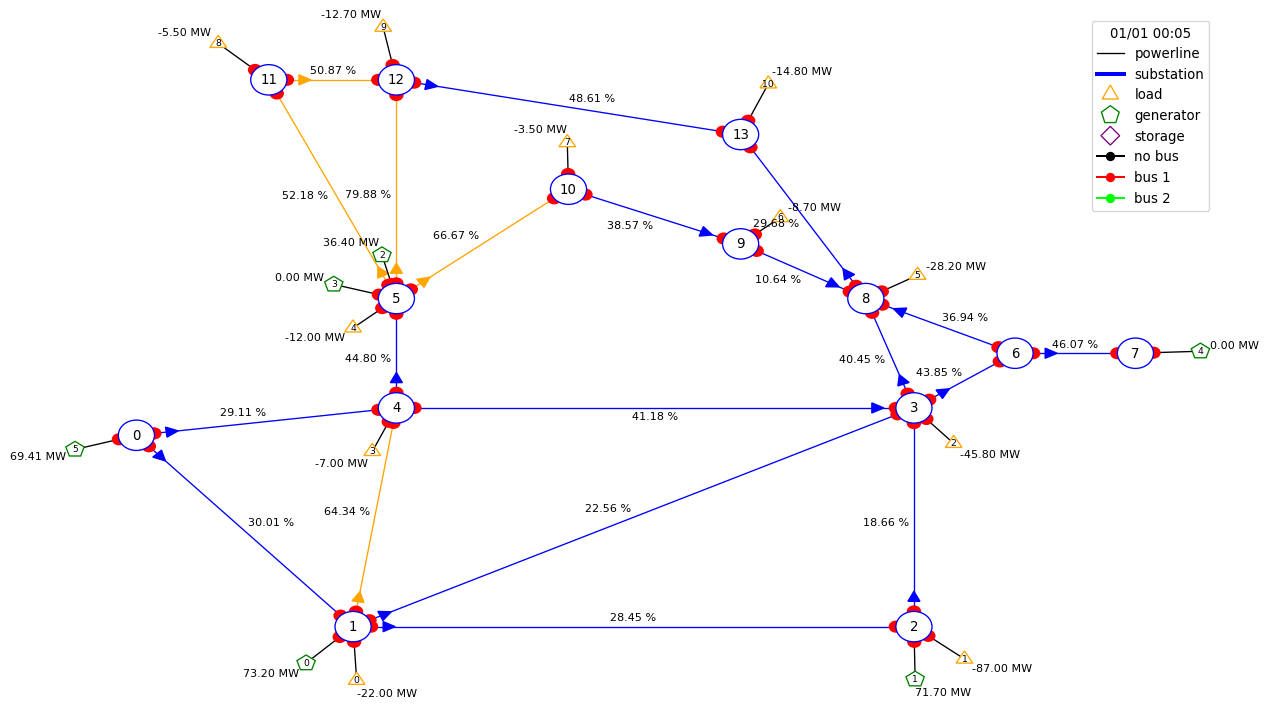

In [5]:
generator.visualize_network()

Once an object of the class `GenerateData` is instanciated (we call it a `generator`), we can generate various distributions for the same experiment. The generator object performe the data generation by calling `generate` function and passing a set of parameters to this function, such as :
- nb_samples : the number of observations 
- tag : indicates the goal of the generated dataset (training, validation, test, super_test)
- reference_number : a number indicating the reference topology of the network, a code book is provided below
| reference_number | Description |
| :- | :- |
| 0 | the reference topology corresponds to a a fully meshed network |
| 1 | the reference topology presents a disconnected line (line 3 which connectes nodes 1 and 3) |
| 2 | the reference topology presents a topological change at a node in the network (node 3) |
| 3 | the reference topology presents a topological change at another node of the network (node 5) |
| 4 | the reference topology presents a topological changes at two nodes of the networks (nodes 3 & 5) |
- agent_generator_name : an agent which can take some actions during the power network life span and which controls the data distribution, the list of possible agents and their descriptions are indicated in the table below
| agent_generator_name | Description |
| :- | :- |
| do_nothing | an agent that does not change the state of the network |
| random_nn1 | an agent that disconnects a line with the probability of p as parameter |
| random_n1 | an agent that disconnects a line |
| random_n2 | an agent that disconnects two lines |
| random_tc_nn1 | an agent that performs a topological change at a node of the network with probability of p |
| random_tc_n1 | an agent that performs a topological change at a node of the network |
| random_tc_n2 | an agent that performs a topological change at two nodes of the network |
- skip_gameover : whether to consider the gameover situations during data generation or not. The consideration of this situations is the purpose of another benchmark and can be used for a classification task

#### load from file
We can load the stored data via `load` function, to reuse the already generated dataset and to save some time for further experiments.

In [5]:
generator.load(path="lips\\Outputs")

####  Generate data from scratch

In the following we generate 4 datasets with different distributions : 
- training dataset : considering random_nn1 agent as generator, the training dataset with over 1 million of examples, presents a distribution including the disconnection of one line or fully meshed network at each iteration. This dataset is used only for training of a model based on machine learning (neural networks);

In [ ]:
generator.generate(nb_samples=int(1024) * int(1024), # attention, it takes a while to generate this size of data
                   tag="training", # this tag indicates that the data is used for training and preprocessing
                   reference_number=0, 
                   agent_generator_name="random_nn1",
                   skip_gameover=True
                  )

- validation : a dataset with the same distribution of training set with less number of examples for the validation of neural networks which allows to analyze the convergence of the model;

In [ ]:
generator.generate(nb_samples=int(1024) * int(128),
                   tag="validation", # this tag indicates that the data is used for validation
                   reference_number=0,
                   agent_generator_name="random_nn1",
                   skip_gameover=True
                  )

- test : a test set to evaluate the performance of the trained models or physics solver like DC approximator which presents the same distribution as the training set;

In [ ]:
generator.generate(nb_samples=int(1024) * int(128),
                   tag="test", # this tag indicates that the data is used for evaluation (same distribution of training dataset)
                   reference_number=0,
                   agent_generator_name="random_n1",
                   skip_gameover=True
                  )

- super_test : which evaluate the generalisation of different models for the inference of out-of-distribution examples. A different generator agent is used for this dataset that allows to disconnect two power lines simultaneously and corresponds to a distribution that has never been seen during the training and validation phases.

In [ ]:
generator.generate(nb_samples=int(1024) * int(128),
                   tag="super_test", # this tag indicates that the data is used for evaluation (out-of-distribution dataset)
                   reference_number=0,
                   agent_generator_name="random_n2",
                   skip_gameover=True
                  )

- test_simple : a simple test set using `do_nothing` agent for DC approximation

In [13]:
generator.generate(nb_samples=int(1024) * int(4),
                   tag="test_simple", # this tag indicates that the data is used for evaluation (same distribution of training dataset)
                   reference_number=0,
                   agent_generator_name="do_nothing",
                   skip_gameover=True
                  )

100%|█████████████████████████████████████████████████████████████████████████████| 4096/4096 [00:04<00:00, 973.25it/s]


#### save to file 
We can store the generated data on disk using `save` function and reload them when we require them

In [14]:
generator.save(path="lips\\Outputs")

<b>Network reference topology visualisation function</b> : to see the network configuration and reference topology, we can visualize the selected power network via the following function.

C:\Users\Milad\Documents\PythonProject\RTE\LIPS\lips\generate_data\GenerateData.py:450: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


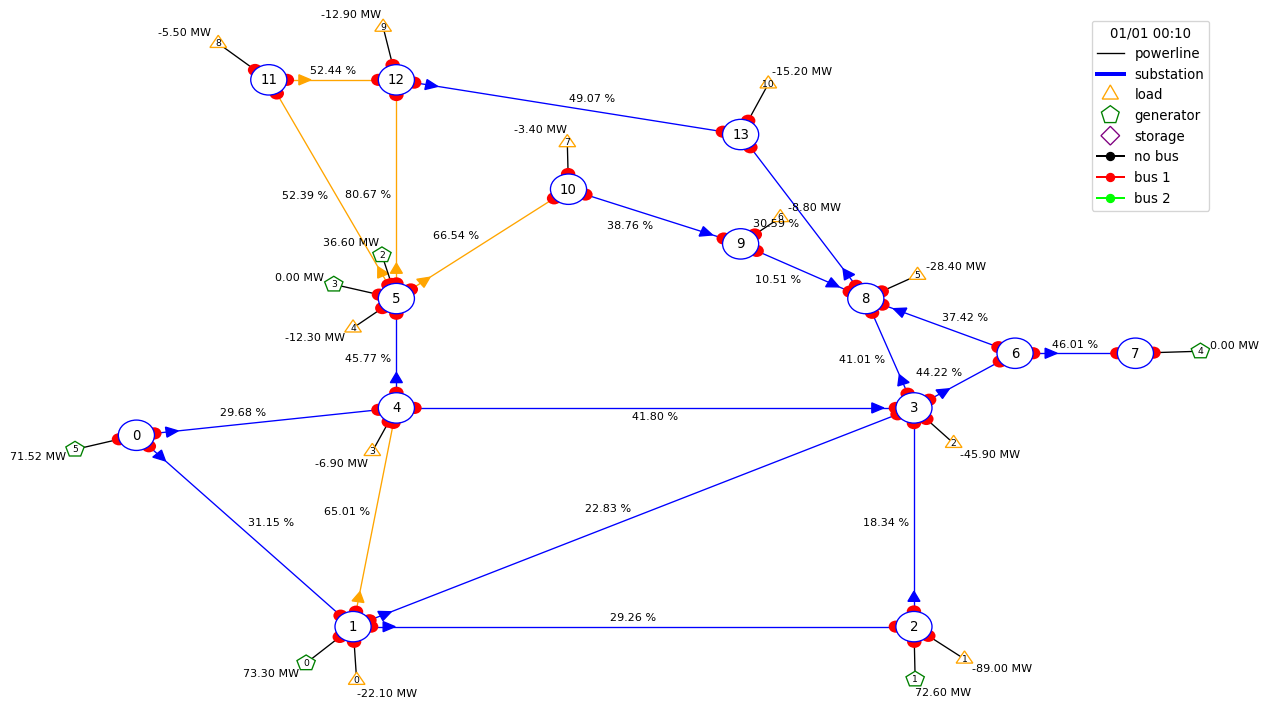

In [6]:
generator.visualize_network_reference_topology(tag="training")

As it can be observed the reference topology corresponds to a fully meshed power network. All the lines are connected and all the element are connected to busbar 1.

<b>Preprocessing : </b> The user could preprocess the data using the preprocess function of this class. The preprocessed data replaces the generated data `dataset` and are only used when a Machine Learning (ML) based model is used for training. A copy of original data is kept in `dataset_original` variable, and are used when a physics solver is used.

In [7]:
# to see if datasets are preprocessed
generator.preprocessed

{'training': False,
 'validation': False,
 'test': False,
 'super_test': False,
 'test_simple': False}

In [8]:
generator.preprocess_data()

In [9]:
# to see if datasets are preprocessed
generator.preprocessed

{'training': True,
 'validation': True,
 'test': True,
 'super_test': True,
 'test_simple': True}

In [10]:
print("Available datasets : ", generator.dataset_available)
print("Dataset sizes : ", generator.dataset_size)
print("dataset dict keys : ", generator.dataset.keys())
print("Reference action description : \n", generator.reference_number)

Available datasets :  {'training': True, 'validation': True, 'test': True, 'super_test': True, 'test_simple': True}
Dataset sizes :  {'training': 1048576, 'validation': 131072, 'test': 131072, 'super_test': 131072, 'test_simple': 4096}
dataset dict keys :  dict_keys(['training', 'validation', 'test', 'super_test', 'test_simple'])
Reference action description : 
 {'training': 0, 'validation': 0, 'test': 0, 'super_test': 0, 'test_simple': 0}


In [11]:
generator.dataset["training"].keys()

dict_keys(['prod_p', 'prod_v', 'load_p', 'load_q', 'line_status', 'topo_vect', 'a_or', 'a_ex', 'p_or', 'p_ex', 'q_or', 'q_ex', 'prod_q', 'load_v', 'v_or', 'v_ex'])

In [12]:
# different available variables with their corresponding lengths
generator.variable_size

{'prod_p': 6,
 'prod_v': 6,
 'load_p': 11,
 'load_q': 11,
 'line_status': 20,
 'topo_vect': 57,
 'a_or': 20,
 'a_ex': 20,
 'p_or': 20,
 'p_ex': 20,
 'q_or': 20,
 'q_ex': 20,
 'prod_q': 6,
 'load_v': 11,
 'v_or': 20,
 'v_ex': 20}

We can see that the training dataset could have a line disconnection from time to time, which is the result of data generation while using a `RandomNN1` agent which disconnects a power line with a probability of `p=0.5` in this case.

In [13]:
# to verify if the actions are taken into account
print(np.sum(generator.dataset["training"]["line_status"],axis=1)[:20])

[1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0.]


we can see blow that the test dataset presents two disconnections for each sample of the dataset. This situation was never been observed during the training and is an out-of-distribution situation. 

In [14]:
print(np.sum(generator.dataset["test"]["line_status"],axis=1)[:20])
print(np.sum(generator.dataset["super_test"]["line_status"],axis=1)[:20])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


### Create a benchmark
Once the data generated using `GenerateData` class, the data are passed to the `Benchmark` class via an object. In Benchmark class, the user could select the inputs and outputs that should be considered for modeling purpose. This module gives the flexibility to select a desired model among the available models (or to be implemented and to be imported by the user). The already developed models are a DC approximator and three neural network based models which are : LeapNet, ResNet and fully connected models. The benchmark class gives the ability to train the models (with the exception of DC approximator which does not require to be trained) and to predict the observations in test datasets. The benchmark results could also be saved and be reloaded for further investigations. Finally, in order to evaluate the performance of the designed benchmark, an object of this class should be passed to Evaluate class, whih in turn provides different domain specific and generic metrics and criteria.
![Benchmarking step](img/Benchmarking.png)

To create a benchmark on the generated data, we should pass a GenerateData object as parameter to Benchmark class. The other attributes of the Benchmark class indicates the variables should be used among the inputs and outputs of a model. 

The table below indicate the exhaustive list of inputs and outputs that can be considered for any model.

| Variable name | Description | - | Output variables | Description |
| :- | :- | :- | :- | :- |
| prod_p | production active power MW |   | <b>a_or & a_ex</b> | current at two extremities of a power line |
| prod_v | production voltage KV |  | v_or & v_ex | voltages at two extremities of power lines  |
| load_p | load active power MW |   | p_or & p_ex | active powers at two extremities of power lines |
| load_q | load reactive power Mvar |   | q_or & q_ex | reactive powers at two extremities of power lines |
| line_status| binary vector indicating if a line is connected |   | load_v | load voltage in KV |
| | | | prod_q | production reactive power in MVar |

For the sake of this benchmark, we use all the inputs. Althought, only the currents are required to be predicted as the objective is to assess the risk through contingency screening and an overload is detected if the value of current $a_{or}$ exceeds a threshold that depends on each line.

In [14]:
benchmark_dc = Benchmark(benchmark_name="benchmark1",
                         generator = generator,
                         attr_x=("prod_p", "prod_v", "load_p", "load_q"),
                         attr_y=("a_or", "a_ex", "p_or", "p_ex", "q_or",
                                 "q_ex", "prod_q", "load_v", "v_or", "v_ex"),
                         attr_tau=("line_status",),
                         path="lips\\Outputs"
                        )

#### Evaluate DC approximation 
As the DC approximator does not require to be learned, a specific evaluation function is designed for this solver. It is also considered as the baseline model for all the comparisons. The `evaluate_dc` function, in its simplest form gets a `tag` of a dataset (corresponding to one of the test datasets) and the `save_path` parameter to save the prediction results. Once, the evaluation is completed, the prediction results will be accessible via `predictions` variable and corresponding true variables are also stored in `observations` variable. These two variables are dictionaries with first level keys representing the tag of a dataset and second level keys representing the name of the predicted variables indicated in `attr_y` argument of `evaluate_dc` function. 

In [20]:
benchmark_dc.evaluate_dc(tag = "test_simple", save_evaluation=True)

100%|██████████████████████████████████████████████████████████████████████████████| 4096/4096 [01:04<00:00, 63.96it/s]


Predictions saved successfully !


In [19]:
benchmark_dc.evaluate_dc(tag = "test", save_evaluation=True)

100%|██████████████████████████████████████████████████████████████████████████| 131072/131072 [50:33<00:00, 43.21it/s]


Predictions saved successfully !


In [28]:
benchmark_dc.evaluate_dc(tag = "super_test", save_evaluation=True)

100%|██████████████████████████████████████████████████████████████████████████| 131072/131072 [51:39<00:00, 42.29it/s]


Predictions saved successfully !


#### Build a statistical learning model (Deep Neural Network)
Once the benchmark is created, if we would like to create a model based on neural nets, users should firstly build a model via `build_model` function. The benchmark platform give the flexibiltiy to users to import their own Tensorflow Model and pass as a parameter to build function of Benchmark class. Afterward, other model specific parameters such as number of layers and neurons, optimizer, loss and metrics could also be customized.

In [15]:
benchmark_ML = Benchmark(benchmark_name="benchmark2",
                         generator = generator,
                         attr_x=("prod_p", "prod_v", "load_p", "load_q"),
                         attr_y=("a_or", "a_ex", "p_or", "p_ex", "q_or",
                                 "q_ex", "prod_q", "load_v", "v_or", "v_ex"),
                         attr_tau=("line_status",),
                         path="lips\\Outputs"
                        )

In [16]:
from lips.models import LeapNet
# for the model parameters, I should use **kwargmodel for a better flexibility
benchmark_ML.build_model(model=LeapNet,
                         sizes_enc=(20,),
                         sizes_main=(150, 150),
                         sizes_out=(40,),
                         lr=3e-4,
                         scale_main_layer=None, 
                         scale_input_dec_layer=None,
                         scale_input_enc_layer=None,
                         layer_act=None,
                         optimizer="adam",
                         loss="mse",
                         metrics=["mean_absolute_error"]
                         )

We can access the built model via `_model` attribute of Benchmark class and to analyze its different characteristics.

In [17]:
benchmark_ML._model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_prod_p (InputLayer)           [(None, 6)]          0                                            
__________________________________________________________________________________________________
x_prod_v (InputLayer)           [(None, 6)]          0                                            
__________________________________________________________________________________________________
x_load_p (InputLayer)           [(None, 11)]         0                                            
__________________________________________________________________________________________________
x_load_q (InputLayer)           [(None, 11)]         0                                            
______________________________________________________________________________________________

#### Train the neural network model
Once the model based on neural networks is built, we should train it on the training dataset generated previously. To do that, we have to call only the train_model function by indicating a set of hyper-parameters.

In [30]:
benchmark_ML.train_model(epochs=5, batch_size=32, verbose=1, save_model=True)

100%|██████████████████████████████████████████████████████████████████████████| 163840/163840 [28:06<00:00, 97.15it/s]


<b>Save the bechmark</b> : the benchmark could be saved for further investigations

In [31]:
benchmark_ML.save()

<b>load a trained model : </b> If the trained model is saved, it is possible to reload it for further investigations using `load` function of Benchmark class.

In [ ]:
benchmark.load(path="lips\\Outputs\\Scenario1\\Benchmarks")

<b>Analysis and visualisation tools : </b> The platform offers a set built-in visualisation and analysis tools to study the model's behavior. As an example, we have visualized the convergence curves using the training and validation datasets. In this graphic, the x-axis corresponds to the epochs and y-axis corresponds to the loss values which is in this case Mean Squared Error (MSE). It should alos be noted that the loss values are averaged over different steps of an epoch.  

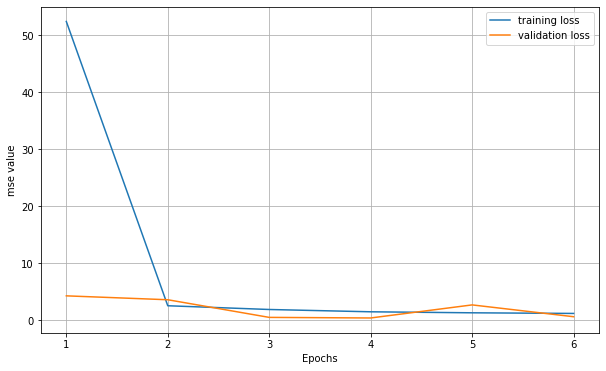

In [32]:
benchmark_ML.plot_convergence()

From the convergence plot, we can note if the model has been converged towards the optimal solution and if there was an over or under fitting problem by considering both training and validation losses.

#### Predict using the trained model 
Once the model is learnt, it can be used to make inference on test data which have never been seen during the training phase. 

<b>Important note : </b>It should be noticed that the platform gives the flexibility to the users to generate multiple test datasets with various distributions and to add a unique tag for each generated dataset. When we would to call the prediction function, the tag parameter should point to the test dataset on which we want make the predictions.

In [33]:
benchmark_ML.predict(batch_size=128,tag="test", verbose=1, save_predictions=True)

100%|██████████████████████████████████████████████████████████████████████████████| 1024/1024 [00:18<00:00, 56.80it/s]


Predictions saved successfully !


In [34]:
benchmark_ML.predict(batch_size=128,tag="super_test", verbose=1, save_predictions=True)

100%|██████████████████████████████████████████████████████████████████████████████| 1024/1024 [00:18<00:00, 56.17it/s]


Predictions saved successfully !


### Evaluation
The third important module of the LIPS platform is the Evaluation module, which aims at evaluating the performance of trained models with respect to various criteria. Each criterion tackles a particular point of view which are

- <b>physics compliances </b> Four functions are developed to evaluate the physics based electricity laws. These functions could be called through `evaluate_physic` function of the `Evaluation` class (by passing True for corresponding verification) and are :
    - BasicVerifier : it performs some elementray verification on different aspect of the network, which are the following:
        * verifying the positivity of current values $a_{or} > 0$ and $a_{ex} > 0$
        * verifying the positivity of voltage values $v_{or} > 0$ and $v_{ex} > 0$
        * verifying the positivity of electrical loss (EL) $p_ex + p_or > 0$. A critierion $-\sum_t \min(EL_t, 0)$ is computed to measure the influence of negative values.
        * verifying the zero values for current, active and reactive powers (a, p and q) in the case of power line disconnection
        * verifying the following equations by computing the divergence between left and right hand side of the equations using Mean Absolute Error (MAE), the denominator is added by an epsilon (very small value) to avoid the division by zero in the case where the voltages are equal to zero $v=0$
            * $a_{or} = \frac{\sqrt{p_{or}^2 + q_{or}^2}}{\sqrt{3}\cdot v_{or}+ \epsilon}$ 
            * $a_{ex} = \frac{\sqrt{p_{ex}^2 + q_{ex}^2}}{\sqrt{3}\cdot v_{ex}+ \epsilon}$
    - Check_loss : it verifies if the ratio of electrical loss wrt the production active power $\frac{p_{or} + p_{ex}}{p_{prod}}.$. This ratio is acceptable if it is situated in the range [1,4] percents. It returns the electrical loss values and the indices of the observations which do not respect the acceptable range.
    - Check_energy_conservation: it verifies the law of conservation of energy (called also LCE) where the productions should be equal to consumptions and electrical loss, or in other words : $p_{prod} = p_{load} + (p_{or} + p_{ex})$. It returns the LCE values which is : $LCE = p_{prod} - p_{load} - (p_{or} + p_{ex})$ and the indices of the observation which does not respect this law at an indicated tolerance.
    - Check_Kirchhoff_current_law: It verifies the Kirchoff's current law. The sum of complex currents (computed via active and reactive powers) entering a node should be equal to sum of the exiting complex currents from that node. It returns the law values computed at each node, added at the network level and the indices of the observations which does not respect the law.


- <b>Machine Learning metrics :</b> various metrics are included to evaluate the performance of the models from accuracy and time complexity point of view.
    - MAPE90 : same as Mean Absolute Percentage Error (MAPE), except that the error is computed on the 10% of lines with the highest voltage values. The prediction of high voltage values are important to ensure the security of power networks;
    -Time complexity (in seconds) : time required for evaluation phase of the models (prediction of power flows).
    - metrics such as MAE, MSE, NRMSE, MAPE, etc.
    
    
- <b>Adaptability : </b> TO BE DISCUSSED AND IMPLEMENTED


- <b>Readiness : </b> TO BE DISCUSSED AND IMPLEMENTED
![Evaluation phase](img/Evaluation.png)

#### Evaluate the DC approximator (do_nothing agent)

In [21]:
evaluator_dc = Evaluation(benchmark_dc, tag="test_simple")

#####  ML-related criteria

In [22]:
evaluator_dc.evaluate_ML(compute_metricsPercentage=True, # whether to compute the metrics on a percentage of data with highest current values
                         metric_percentage=["mape", "MAE"], # the metrics used for this purpose
                         k=0.1,# the proportion of data to be considered for this metric
                         verbose=0) 

In [23]:
print("Inference time of the selected model : ", evaluator_dc.metrics_ML["test_time"])
print("Mean Absolute Percentage Error averaged over all the nodes : ") 
pprint(evaluator_dc.metrics_ML["mape_avg"])
print("MAPE90")
pprint(evaluator_dc.metrics_ML["mape10"])

Inference time of the selected model :  28.827651262283325
Mean Absolute Percentage Error averaged over all the nodes : 
{'a_ex': 0.21725693153428485,
 'a_or': 0.22909624045996207,
 'load_v': 0.032809324246772055,
 'p_ex': 0.10102460747844037,
 'p_or': 0.10586949439092552,
 'prod_q': 0.728586030573572,
 'q_ex': 1.0,
 'q_or': 1.0,
 'v_ex': 0.03347927467141564,
 'v_or': 0.02145334285880384}
MAPE90
{'a_or': 0.5128504091568424,
 'p_or': 0.04052962580742235,
 'q_or': 1.0,
 'v_or': 0.046387804873254695}


##### Physics compliances

In [24]:
evaluator_dc.evaluate_physic(choice="real")

************* Basic verifier *************
Current positivity check passed for origin side !
----------------------------------------------
Current positivity check passed for extremity side !
----------------------------------------------
Voltage positivity check passed for origin side !
----------------------------------------------
Voltage positivity check passed for extremity side !
----------------------------------------------
0.804% of lines does not respect the positivity of loss (Mw)
Concerned lines with corresponding number of negative loss values:
 {18: 659}
----------------------------------------------
Prediction in presence of line disconnection. Check passed !
----------------------------------------------
************* Check loss *************
Verification is done without any violation !
************* Check Energy Conservation *************
Number of failed cases is 0 and the proportion is 0.000% : 
************* Check kirchhoff's current law *************
0.00% not ver

In [25]:
evaluator_dc.evaluate_physic(choice="predictions")

************* Basic verifier *************
Current positivity check passed for origin side !
----------------------------------------------
Current positivity check passed for extremity side !
----------------------------------------------
Voltage positivity check passed for origin side !
----------------------------------------------
Voltage positivity check passed for extremity side !
----------------------------------------------
Loss positivity check passed !
----------------------------------------------
Prediction in presence of line disconnection. Check passed !
----------------------------------------------
************* Check loss *************
Verification is done without any violation !
************* Check Energy Conservation *************
Number of failed cases is 4096 and the proportion is 100.000% : 
************* Check kirchhoff's current law *************
7.14% not verify the Kirchhoff's current law at 0.01 tolerance


#### Evaluate the neural network based model 

In [35]:
evaluator_nn = Evaluation(benchmark_ML, tag="test")

##### Evaluate on test set (same distribution as the training set)

<b>ML-related criteria</b>

In [36]:
evaluator_nn.evaluate_ML(compute_metricsPercentage=True, # whether to compute the metrics on a percentage of data with highest current values
                         metric_percentage=["mape", "MAE"], # the metrics used for this purpose
                         k=0.1,
                         verbose=0) # the proportion of data to be considered for this metric

In [39]:
print("Inference time of the selected model : ", evaluator_nn.metrics_ML["test_time"])
print("NRMSE : ")
pprint(evaluator_nn.metrics_ML["NRMSE_avg"])
print("Mean Absolute Percentage Error averaged over all the nodes : ") 
pprint(evaluator_nn.metrics_ML["mape_avg"])
print("MAPE90")
pprint(evaluator_nn.metrics_ML["mape10"])

Inference time of the selected model :  123.75592374801636
NRMSE : 
{'a_ex': 0.12837673532560426,
 'a_or': 0.10782829592713764,
 'load_v': 0.017680446295039797,
 'p_ex': 0.019050768042285067,
 'p_or': 0.02178442472625156,
 'prod_q': 0.022607313506979903,
 'q_ex': 0.021483113487417008,
 'q_or': 0.022504817588702118,
 'v_ex': 0.009580523236200397,
 'v_or': 0.006498561328816538}
Mean Absolute Percentage Error averaged over all the nodes : 
{'a_ex': 0.3130407031116579,
 'a_or': 0.2517810506858799,
 'load_v': 0.0006448425299617364,
 'p_ex': 0.049921022656946576,
 'p_or': 0.054707897702883576,
 'prod_q': 0.019299769405498213,
 'q_ex': 0.05738881902991759,
 'q_or': 0.05797608808482098,
 'v_ex': 0.005238806863455283,
 'v_or': 0.0023689588350851425}
MAPE90
{'a_or': 0.1310749038892118,
 'p_or': 0.03875263720920419,
 'q_or': 0.05224047013067541,
 'v_or': 0.003527238697703606}


<b>Physics compliances</b>

In [25]:
evaluator_nn.evaluate_physic(choice="real")

************* Basic verifier *************
Current positivity check passed for origin side !
----------------------------------------------
Current positivity check passed for extremity side !
----------------------------------------------
Voltage positivity check passed for origin side !
----------------------------------------------
Voltage positivity check passed for extremity side !
----------------------------------------------
1.490% of lines does not respect the positivity of loss (Mw)
Concerned lines with corresponding number of negative loss values:
 {18: 33903, 15: 3319, 19: 1844}
----------------------------------------------
Prediction in presence of line disconnection. Check passed !
----------------------------------------------
************* Check loss *************
Verification is done without any violation !
************* Check Energy Conservation *************
Number of failed cases is 0 and the proportion is 0.000% : 
************* Check kirchhoff's current law *****

In [40]:
evaluator_nn.evaluate_physic(choice="predictions")

************* Basic verifier *************
0.389% of lines does not respect the positivity of currents (Amp) at origin
Concerned lines with corresponding number of negative current values at their origin:
 {10: 7147, 1: 1496, 4: 1047, 3: 270, 5: 202, 14: 19, 17: 15, 16: 4}
----------------------------------------------
4.629% of lines does not respect the positivity of currents (Amp) at extremity
Concerned lines with corresponding number of negative current values at their extremity:
 {10: 79128, 3: 18125, 13: 10658, 14: 7293, 8: 1727, 6: 1697, 1: 1283, 11: 1183, 18: 155, 5: 80, 4: 18, 0: 1}
----------------------------------------------
Voltage positivity check passed for origin side !
----------------------------------------------
Voltage positivity check passed for extremity side !
----------------------------------------------
40.480% of lines does not respect the positivity of loss (Mw)
Concerned lines with corresponding number of negative loss values:
 {1: 103982, 10: 94181, 17: 

#####  Evaluate on super test (out-of-distribution)

In [42]:
evaluator_nn = Evaluation(benchmark_ML, tag="super_test")

In [43]:
evaluator_nn.evaluate_ML(verbose=0)

In [44]:
print("Inference time of the selected model : ", evaluator_nn.metrics_ML["test_time"])
print("NRMSE : ")
pprint(evaluator_nn.metrics_ML["NRMSE_avg"])
print("Mean Absolute Percentage Error averaged over all the nodes : ") 
pprint(evaluator_nn.metrics_ML["mape_avg"])
print("MAPE90")
pprint(evaluator_nn.metrics_ML["mape10"])

Inference time of the selected model :  123.75592374801636
NRMSE : 
{'a_ex': 0.16928606452286413,
 'a_or': 0.20225854823119507,
 'load_v': 0.06802512714686039,
 'p_ex': 0.06949269053275636,
 'p_or': 0.07961945907050609,
 'prod_q': 0.06430484840440127,
 'q_ex': 0.07315577459761577,
 'q_or': 0.07597856779308164,
 'v_ex': 0.050074019583959885,
 'v_or': 0.0185663541040329}
Mean Absolute Percentage Error averaged over all the nodes : 
{'a_ex': 0.4620448321127033,
 'a_or': 0.4501472709231941,
 'load_v': 0.004584253093502448,
 'p_ex': nan,
 'p_or': nan,
 'prod_q': 0.0746477063018365,
 'q_ex': 0.27499854808147806,
 'q_or': 0.25784960514761257,
 'v_ex': 0.022107786072128682,
 'v_or': 0.006141979359064747}
MAPE90
{'a_or': 0.3181142315823168,
 'p_or': 0.21544839104709754,
 'q_or': 0.20972473062371805,
 'v_or': 0.010547755604028732}


In [45]:
evaluator_nn.evaluate_physic(choice="predictions")

************* Basic verifier *************
2.628% of lines does not respect the positivity of currents (Amp) at origin
Concerned lines with corresponding number of negative current values at their origin:
 {10: 9921, 1: 8128, 0: 6289, 6: 6046, 2: 5563, 11: 4572, 3: 4537, 4: 4047, 9: 3886, 14: 3845, 5: 2743, 13: 2414, 18: 1712, 16: 1613, 19: 1088, 8: 1073, 15: 590, 17: 530, 7: 293}
----------------------------------------------
7.327% of lines does not respect the positivity of currents (Amp) at extremity
Concerned lines with corresponding number of negative current values at their extremity:
 {10: 74278, 3: 26442, 14: 15813, 13: 15334, 8: 15260, 11: 11806, 6: 7886, 1: 7523, 18: 4377, 5: 3775, 2: 3502, 0: 2340, 9: 2071, 19: 977, 4: 617, 16: 58, 17: 9}
----------------------------------------------
Voltage positivity check passed for origin side !
----------------------------------------------
Voltage positivity check passed for extremity side !
------------------------------------------

## Scenario 2 : Reference topology presenting on disconnected line

In [27]:
generator_2 = GenerateData(experiment_name="Scenario2",
                           env_name="l2rpn_case14_sandbox",
                           attr_x=("prod_p", "prod_v", "load_p", "load_q"),
                           attr_tau=("line_status", "topo_vect"),
                           attr_y=("a_or", "a_ex", "p_or", "p_ex", "q_or",
                                   "q_ex", "prod_q", "load_v", "v_or", "v_ex"),
                           use_lightsim_if_available=True
                          )

C:\Users\Milad\Anaconda3\envs\RTE\lib\site-packages\lightsim2grid\_aux_add_trafo.py:33: UserWarning: There were some Nan in the pp_net.trafo["tap_neutral"], they have been replaced by 0
  warnings.warn("There were some Nan in the pp_net.trafo[\"tap_neutral\"], they have been replaced by 0")
C:\Users\Milad\Anaconda3\envs\RTE\lib\site-packages\lightsim2grid\_aux_add_trafo.py:41: UserWarning: There were some Nan in the pp_net.trafo["tap_step_percent"], they have been replaced by 0
  warnings.warn("There were some Nan in the pp_net.trafo[\"tap_step_percent\"], they have been replaced by 0")
C:\Users\Milad\Anaconda3\envs\RTE\lib\site-packages\lightsim2grid\_aux_add_trafo.py:46: UserWarning: There were some Nan in the pp_net.trafo["tap_pos"], they have been replaced by 0
  warnings.warn("There were some Nan in the pp_net.trafo[\"tap_pos\"], they have been replaced by 0")


<b>Reference number 1 :</b> network presents a power line disconnection as reference topology

In [28]:
generator_2.generate(nb_samples=int(1024) * int(4),
                     tag="training",
                     reference_number=1,
                     agent_generator_name="random_nn1",
                     skip_gameover=True)

100%|█████████████████████████████████████████████████████████████████████████████| 4096/4096 [00:05<00:00, 750.98it/s]


In [ ]:
generator_2.generate(nb_samples=int(1024) * int(4),
                     tag="validation",
                     reference_number=1,
                     agent_generator_name="random_nn1",
                     skip_gameover=True)

In [ ]:
generator_2.generate(nb_samples=int(1024) * int(2),
                     tag="test",
                     reference_number=1,
                     agent_generator_name="random_n1",
                     skip_gameover=True)

In [ ]:
generator_2.generate(nb_samples=int(1024) * int(2),
                     tag="super_test",
                     reference_number=1,
                     agent_generator_name="random_n2",
                     skip_gameover=True)

In [30]:
generator_2.save(path="lips\\Outputs")

<b>Visualization of reference topology</b>

C:\Users\Milad\Documents\PythonProject\RTE\LIPS\generate_data\GenerateData.py:451: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


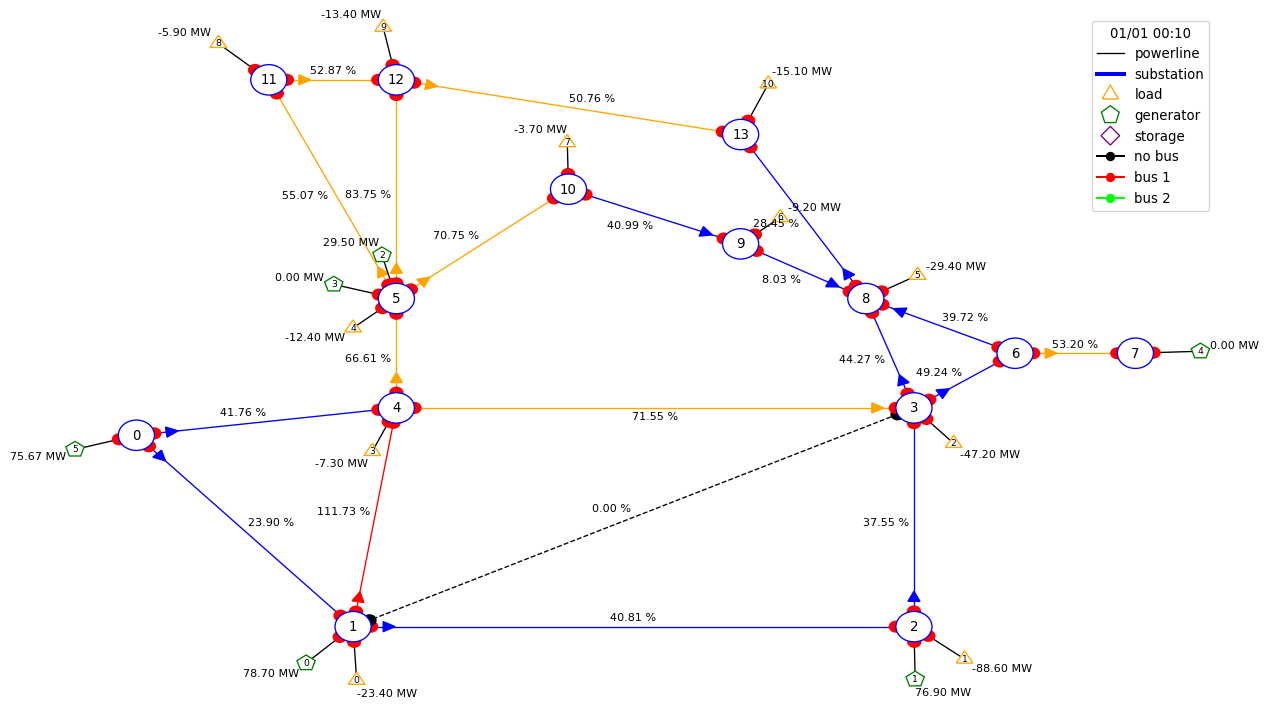

In [31]:
generator_2.visualize_network_reference_topology(tag="training")

As it can be observed, in this scenario, the reference topology present a line disconnection between nodes 1 and 3 of the power grid.

In [ ]:
print(generator_2.reference_number)

In [ ]:
np.sum(generator_2.dataset["training"]["line_status"],axis=1)[0:20]

In [ ]:
np.sum(generator_2.dataset["test"]["line_status"],axis=1)[0:20]

In [ ]:
generator_2.dataset["training"]["topo_vect"][10]

In [ ]:
generator_2.dataset["test"]["topo_vect"][10]

## Scenario 3 : Reference topology presenting one topological change (node 3)

In [32]:
generator_3 = GenerateData(experiment_name="Scenario3",
                           env_name="l2rpn_case14_sandbox",
                           attr_x=("prod_p", "prod_v", "load_p", "load_q"),
                           attr_tau=("line_status", "topo_vect"),
                           attr_y=("a_or", "a_ex", "p_or", "p_ex", "q_or",
                                   "q_ex", "prod_q", "load_v", "v_or", "v_ex"),
                           use_lightsim_if_available=True
                          )

C:\Users\Milad\Anaconda3\envs\RTE\lib\site-packages\lightsim2grid\_aux_add_trafo.py:33: UserWarning: There were some Nan in the pp_net.trafo["tap_neutral"], they have been replaced by 0
  warnings.warn("There were some Nan in the pp_net.trafo[\"tap_neutral\"], they have been replaced by 0")
C:\Users\Milad\Anaconda3\envs\RTE\lib\site-packages\lightsim2grid\_aux_add_trafo.py:41: UserWarning: There were some Nan in the pp_net.trafo["tap_step_percent"], they have been replaced by 0
  warnings.warn("There were some Nan in the pp_net.trafo[\"tap_step_percent\"], they have been replaced by 0")
C:\Users\Milad\Anaconda3\envs\RTE\lib\site-packages\lightsim2grid\_aux_add_trafo.py:46: UserWarning: There were some Nan in the pp_net.trafo["tap_pos"], they have been replaced by 0
  warnings.warn("There were some Nan in the pp_net.trafo[\"tap_pos\"], they have been replaced by 0")


<b>Reference number 2 :</b> Network presents a topological change (bus change) at substation 3

In [33]:
generator_3.generate(nb_samples=int(1024) * int(4),
                     tag="training",
                     reference_number=2,
                     agent_generator_name="random_nn1",
                     skip_gameover=True)

100%|██████████████████████████████████████████████████████████████████████████████| 4096/4096 [01:40<00:00, 40.77it/s]


In [ ]:
generator_3.generate(nb_samples=int(1024) * int(4),
                     tag="test",
                     reference_number=2,
                     agent_generator_name="random_n1",
                     skip_gameover=True)

In [ ]:
generator_3.generate(nb_samples=int(1024) * int(4),
                     tag="super_test",
                     reference_number=2,
                     agent_generator_name="random_n2",
                     skip_gameover=True)

<b>Visualization of reference topology</b>

C:\Users\Milad\Documents\PythonProject\RTE\LIPS\generate_data\GenerateData.py:451: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


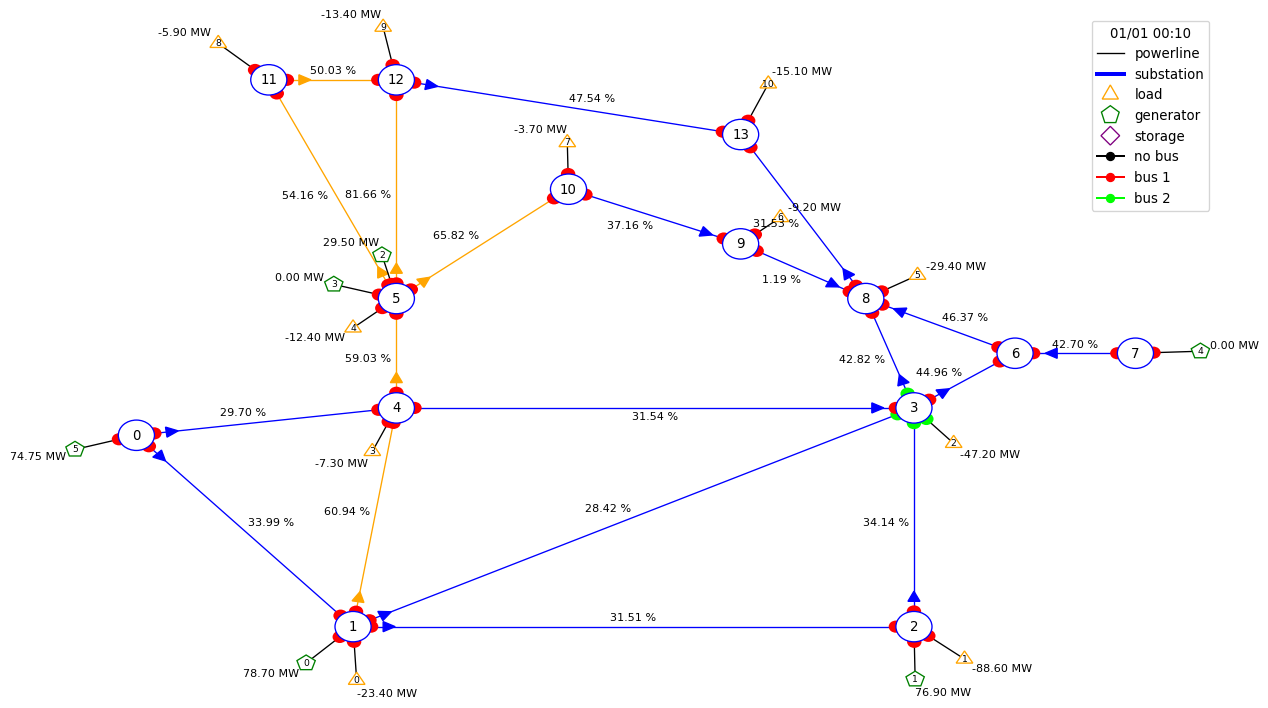

In [34]:
generator_3.visualize_network_reference_topology(tag="training")

As it can be observed, in this scenario, the reference topology presents topological changes at node 3 of the power grid.

## Scenario 4 : Reference topology presenting another topological change (node 5)

In [35]:
generator_4 = GenerateData(experiment_name="Scenario4",
                           env_name="l2rpn_case14_sandbox",
                           attr_x=("prod_p", "prod_v", "load_p", "load_q"),
                           attr_tau=("line_status", "topo_vect"),
                           attr_y=("a_or", "a_ex", "p_or", "p_ex", "q_or",
                                   "q_ex", "prod_q", "load_v", "v_or", "v_ex"),
                           use_lightsim_if_available=True
                          )

C:\Users\Milad\Anaconda3\envs\RTE\lib\site-packages\lightsim2grid\_aux_add_trafo.py:33: UserWarning: There were some Nan in the pp_net.trafo["tap_neutral"], they have been replaced by 0
  warnings.warn("There were some Nan in the pp_net.trafo[\"tap_neutral\"], they have been replaced by 0")
C:\Users\Milad\Anaconda3\envs\RTE\lib\site-packages\lightsim2grid\_aux_add_trafo.py:41: UserWarning: There were some Nan in the pp_net.trafo["tap_step_percent"], they have been replaced by 0
  warnings.warn("There were some Nan in the pp_net.trafo[\"tap_step_percent\"], they have been replaced by 0")
C:\Users\Milad\Anaconda3\envs\RTE\lib\site-packages\lightsim2grid\_aux_add_trafo.py:46: UserWarning: There were some Nan in the pp_net.trafo["tap_pos"], they have been replaced by 0
  warnings.warn("There were some Nan in the pp_net.trafo[\"tap_pos\"], they have been replaced by 0")


<b>Reference number 3 :</b> Network presents a topological change (bus change) at substation 5

In [36]:
generator_4.generate(nb_samples=int(1024) * int(4),
                     tag="training",
                     reference_number=3,
                     agent_generator_name="random_nn1",
                     skip_gameover=True)

100%|██████████████████████████████████████████████████████████████████████████████| 4096/4096 [01:45<00:00, 38.76it/s]


In [ ]:
generator_4.generate(nb_samples=int(1024) * int(4),
                     tag="test",
                     reference_number=3,
                     agent_generator_name="random_n1",
                     skip_gameover=True)

In [ ]:
generator_4.generate(nb_samples=int(1024) * int(4),
                     tag="super_test",
                     reference_number=3,
                     agent_generator_name="random_n2",
                     skip_gameover=True)

<b>Visualization of reference topology</b>

C:\Users\Milad\Documents\PythonProject\RTE\LIPS\generate_data\GenerateData.py:451: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


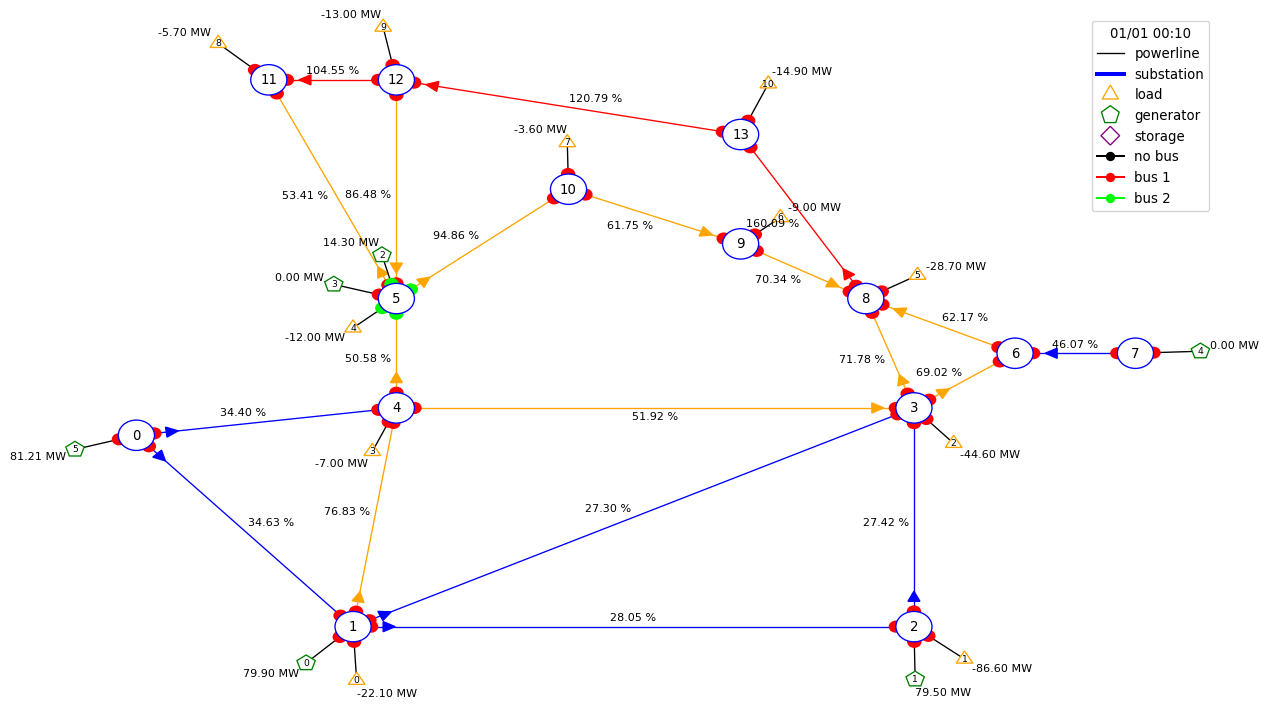

In [37]:
generator_4.visualize_network_reference_topology(tag="training")

As it can be observed, in this scenario, the reference topology presents topological changes at node 5 of the power grid.

## Scenario 5 : Reference topology presenting two simultaneous topological changes (nodes 3 and 5)

In [38]:
generator_5 = GenerateData(experiment_name="Scenario5",
                           env_name="l2rpn_case14_sandbox",
                           attr_x=("prod_p", "prod_v", "load_p", "load_q"),
                           attr_tau=("line_status", "topo_vect"),
                           attr_y=("a_or", "a_ex", "p_or", "p_ex", "q_or",
                                   "q_ex", "prod_q", "load_v", "v_or", "v_ex"),
                           use_lightsim_if_available=True
                          )

C:\Users\Milad\Anaconda3\envs\RTE\lib\site-packages\lightsim2grid\_aux_add_trafo.py:33: UserWarning: There were some Nan in the pp_net.trafo["tap_neutral"], they have been replaced by 0
  warnings.warn("There were some Nan in the pp_net.trafo[\"tap_neutral\"], they have been replaced by 0")
C:\Users\Milad\Anaconda3\envs\RTE\lib\site-packages\lightsim2grid\_aux_add_trafo.py:41: UserWarning: There were some Nan in the pp_net.trafo["tap_step_percent"], they have been replaced by 0
  warnings.warn("There were some Nan in the pp_net.trafo[\"tap_step_percent\"], they have been replaced by 0")
C:\Users\Milad\Anaconda3\envs\RTE\lib\site-packages\lightsim2grid\_aux_add_trafo.py:46: UserWarning: There were some Nan in the pp_net.trafo["tap_pos"], they have been replaced by 0
  warnings.warn("There were some Nan in the pp_net.trafo[\"tap_pos\"], they have been replaced by 0")


<b>Reference number 4 :</b> Network presents two topological changes (bus changes) at substations 3 and 5

In [39]:
generator_5.generate(nb_samples=int(1024) * int(4),
                     tag="training",
                     reference_number=4,
                     agent_generator_name="random_nn1",
                     skip_gameover=True)

100%|██████████████████████████████████████████████████████████████████████████████| 4096/4096 [34:48<00:00,  1.96it/s]


In [ ]:
generator_5.generate(nb_samples=int(1024) * int(4),
                     tag="test",
                     reference_number=4,
                     agent_generator_name="random_n1",
                     skip_gameover=True)

In [ ]:
generator_5.generate(nb_samples=int(1024) * int(4),
                     tag="super_test",
                     reference_number=4,
                     agent_generator_name="random_n2",
                     skip_gameover=True)

<b>Visualization of reference topology</b>

C:\Users\Milad\Documents\PythonProject\RTE\LIPS\generate_data\GenerateData.py:451: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


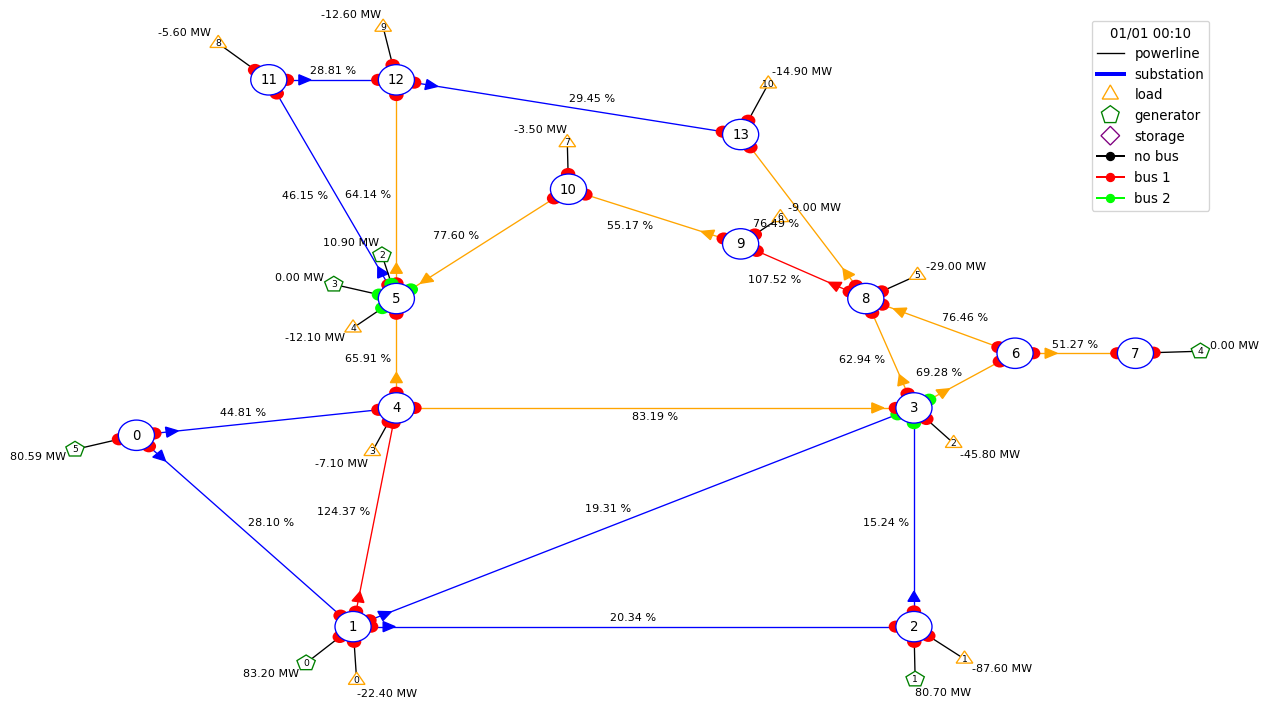

In [40]:
generator_5.visualize_network_reference_topology(tag="training")

As it can be observed, in this scenario, the reference topology presents topological changes at nodes 3 and 5 of the power grid.